# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-442198fe-c4ed-4182-d6a6-b067ef37abcd)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-07 03:10:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2023-03-07 03:10:14 (38.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


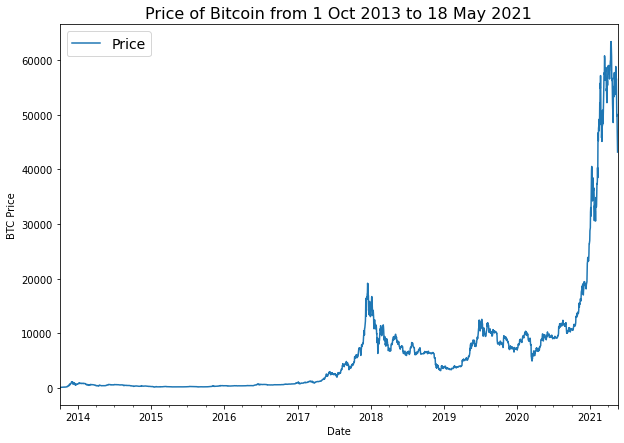

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

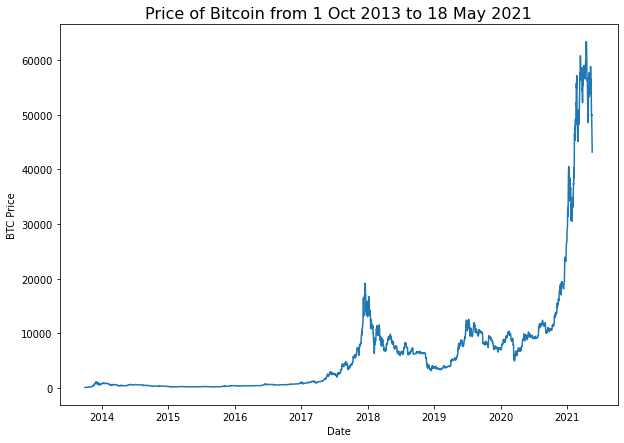

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

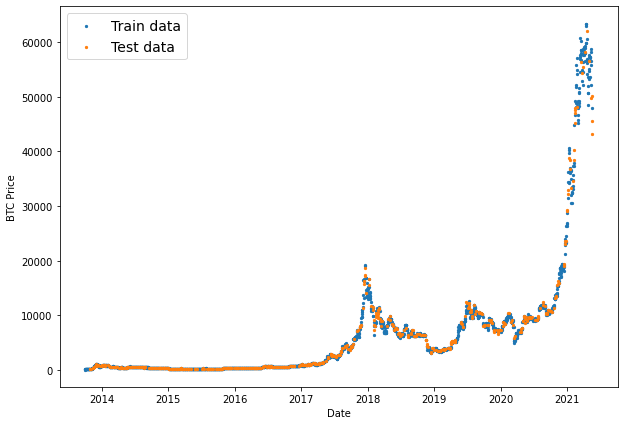

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

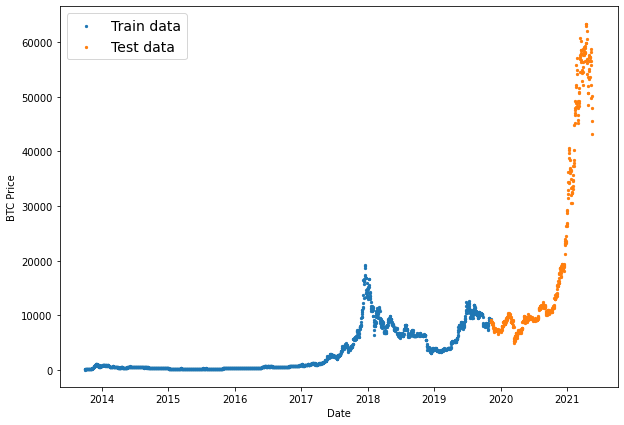

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

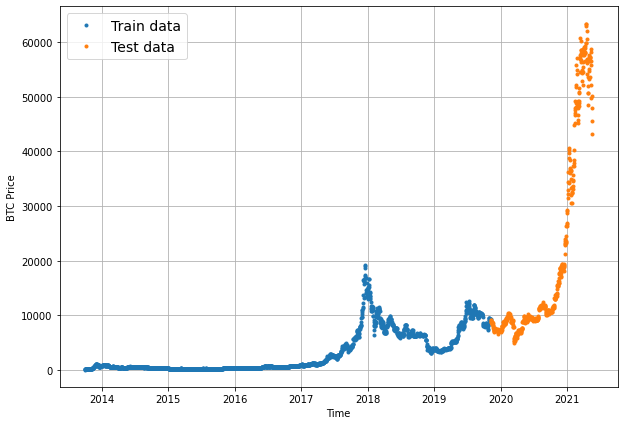

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

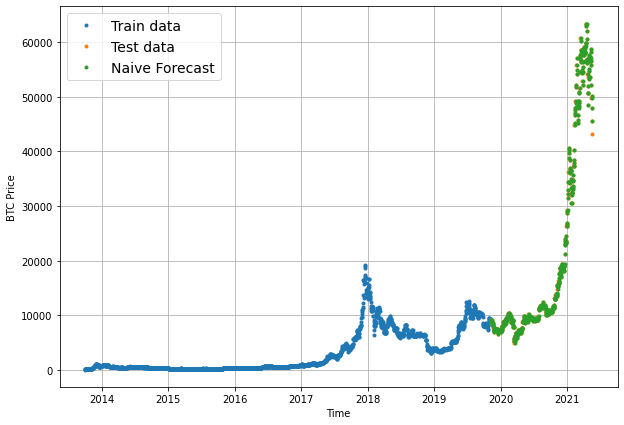

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

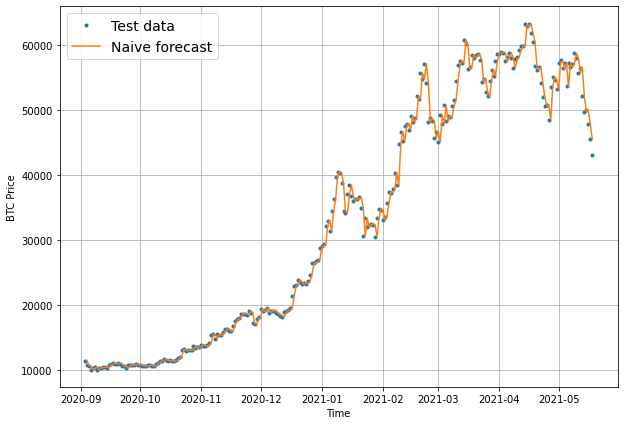

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 1678.1816 - mae: 1678.1816  

18/18 [==============================] - 7s 75ms/step - loss: 1245.6665 - mae: 1245.6665 - val_loss: 2848.2729 - val_mae: 2848.2729
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 349.8239 - mae: 349.8239

18/18 [==============================] - 1s 58ms/step - loss: 327.5056 - mae: 327.5056 - val_loss: 1305.7540 - val_mae: 1305.7540
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 196.8540 - mae: 196.8540

18/18 [==============================] - 1s 47ms/step - loss: 193.4154 - mae: 193.4154 - val_loss: 1144.4303 - val_mae: 1144.4303
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 233.5020 - mae: 233.5020

18/18 [==============================] - 1s 35ms/step - loss: 177.8818 - mae: 177.8818 - val_loss: 965.0159 - val_mae: 965.0159
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 181.7968 - mae: 181.7968

18/18 [==============================] - 1s 33ms/step - loss: 170.5854 - mae: 170.5854 - val_loss: 943.5522 - val_mae: 943.5522
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 123.5059 - mae: 123.5059

18/18 [==============================] - 1s 62ms/step - loss: 167.8146 - mae: 167.8146 - val_loss: 914.6357 - val_mae: 914.6357
Epoch 7/100
10/18 [===============>..............] - ETA: 0s - loss: 174.5773 - mae: 174.5773

18/18 [==============================] - 2s 108ms/step - loss: 160.1486 - mae: 160.1486 - val_loss: 897.0517 - val_mae: 897.0517
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 157.9015 - mae: 157.9015

18/18 [==============================] - 1s 63ms/step - loss: 157.9015 - mae: 157.9015 - val_loss: 869.9985 - val_mae: 869.9985
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 155.4720 - mae: 155.4720 - val_loss: 879.6208 - val_mae: 879.6208
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 146.1622 - mae: 146.1622

18/18 [==============================] - 2s 135ms/step - loss: 150.2062 - mae: 150.2062 - val_loss: 817.2480 - val_mae: 817.2480
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 145.9066 - mae: 145.9066

18/18 [==============================] - 1s 79ms/step - loss: 145.6093 - mae: 145.6093 - val_loss: 802.1150 - val_mae: 802.1150
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 141.8954 - mae: 141.8954 - val_loss: 855.5023 - val_mae: 855.5023
Epoch 13/100
11/18 [=================>............] - ETA: 0s - loss: 137.6329 - mae: 137.6329

18/18 [==============================] - 1s 73ms/step - loss: 141.7698 - mae: 141.7698 - val_loss: 779.3548 - val_mae: 779.3548
Epoch 14/100
11/18 [=================>............] - ETA: 0s - loss: 131.5005 - mae: 131.5005

18/18 [==============================] - 1s 77ms/step - loss: 136.4526 - mae: 136.4526 - val_loss: 761.1492 - val_mae: 761.1492
Epoch 15/100
16/18 [=========================>....] - ETA: 0s - loss: 138.1056 - mae: 138.1056

18/18 [==============================] - 1s 83ms/step - loss: 136.4712 - mae: 136.4712 - val_loss: 736.7006 - val_mae: 736.7006
Epoch 16/100
18/18 [==============================] - 0s 10ms/step - loss: 132.8114 - mae: 132.8114 - val_loss: 750.7463 - val_mae: 750.7463
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 130.7402 - mae: 130.7402 - val_loss: 785.0217 - val_mae: 785.0217
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 133.0518 - mae: 133.0518

18/18 [==============================] - 1s 78ms/step - loss: 132.2739 - mae: 132.2739 - val_loss: 709.0482 - val_mae: 709.0482
Epoch 19/100
18/18 [==============================] - 0s 12ms/step - loss: 127.7920 - mae: 127.7920 - val_loss: 723.7698 - val_mae: 723.7698
Epoch 20/100
18/18 [==============================] - 0s 9ms/step - loss: 125.5490 - mae: 125.5490 - val_loss: 723.4233 - val_mae: 723.4233
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 130.8589 - mae: 130.8589

18/18 [==============================] - 1s 78ms/step - loss: 130.8490 - mae: 130.8490 - val_loss: 671.0167 - val_mae: 671.0167
Epoch 22/100
18/18 [==============================] - 0s 9ms/step - loss: 123.1966 - mae: 123.1966 - val_loss: 673.9446 - val_mae: 673.9446
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 123.3415 - mae: 123.3415

18/18 [==============================] - 1s 77ms/step - loss: 124.3040 - mae: 124.3040 - val_loss: 654.5281 - val_mae: 654.5281
Epoch 24/100
11/18 [=================>............] - ETA: 0s - loss: 125.5580 - mae: 125.5580

18/18 [==============================] - 2s 126ms/step - loss: 123.6568 - mae: 123.6568 - val_loss: 646.6069 - val_mae: 646.6069
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 125.5308 - mae: 125.5308

18/18 [==============================] - 1s 82ms/step - loss: 121.0664 - mae: 121.0664 - val_loss: 641.7749 - val_mae: 641.7749
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 119.8381 - mae: 119.8381

18/18 [==============================] - 1s 87ms/step - loss: 119.8381 - mae: 119.8381 - val_loss: 634.5005 - val_mae: 634.5005
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 120.3459 - mae: 120.3459

18/18 [==============================] - 1s 73ms/step - loss: 120.4200 - mae: 120.4200 - val_loss: 626.7735 - val_mae: 626.7735
Epoch 28/100
10/18 [===============>..............] - ETA: 0s - loss: 121.3397 - mae: 121.3397

18/18 [==============================] - 1s 74ms/step - loss: 117.4107 - mae: 117.4107 - val_loss: 624.8870 - val_mae: 624.8870
Epoch 29/100
11/18 [=================>............] - ETA: 0s - loss: 116.5718 - mae: 116.5718

18/18 [==============================] - 1s 52ms/step - loss: 116.5526 - mae: 116.5526 - val_loss: 618.1268 - val_mae: 618.1268
Epoch 30/100
12/18 [===================>..........] - ETA: 0s - loss: 118.9265 - mae: 118.9265

18/18 [==============================] - 1s 58ms/step - loss: 119.6944 - mae: 119.6944 - val_loss: 614.5587 - val_mae: 614.5587
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 117.9385 - mae: 117.9385 - val_loss: 618.4364 - val_mae: 618.4364
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 111.0790 - mae: 111.0790

18/18 [==============================] - 1s 54ms/step - loss: 115.7344 - mae: 115.7344 - val_loss: 613.4380 - val_mae: 613.4380
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1269 - mae: 115.1269 - val_loss: 634.3510 - val_mae: 634.3510
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 119.0096 - mae: 119.0096

18/18 [==============================] - 1s 81ms/step - loss: 114.4880 - mae: 114.4880 - val_loss: 609.2098 - val_mae: 609.2098
Epoch 35/100
10/18 [===============>..............] - ETA: 0s - loss: 112.2694 - mae: 112.2694

18/18 [==============================] - 1s 55ms/step - loss: 112.7261 - mae: 112.7261 - val_loss: 604.8112 - val_mae: 604.8112
Epoch 36/100
18/18 [==============================] - 0s 12ms/step - loss: 117.2023 - mae: 117.2023 - val_loss: 605.7551 - val_mae: 605.7551
Epoch 37/100
18/18 [==============================] - ETA: 0s - loss: 114.9648 - mae: 114.9648

18/18 [==============================] - 2s 92ms/step - loss: 114.9648 - mae: 114.9648 - val_loss: 594.9562 - val_mae: 594.9562
Epoch 38/100
18/18 [==============================] - 0s 11ms/step - loss: 115.2543 - mae: 115.2543 - val_loss: 606.2937 - val_mae: 606.2937
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 114.2900 - mae: 114.2900 - val_loss: 604.8214 - val_mae: 604.8214
Epoch 40/100
11/18 [=================>............] - ETA: 0s - loss: 110.7892 - mae: 110.7892

18/18 [==============================] - 1s 50ms/step - loss: 112.3699 - mae: 112.3699 - val_loss: 589.0861 - val_mae: 589.0861
Epoch 41/100
18/18 [==============================] - 0s 10ms/step - loss: 112.1384 - mae: 112.1384 - val_loss: 672.0884 - val_mae: 672.0884
Epoch 42/100
18/18 [==============================] - 0s 8ms/step - loss: 116.3869 - mae: 116.3869 - val_loss: 624.7791 - val_mae: 624.7791
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 116.6782 - mae: 116.6782 - val_loss: 636.1269 - val_mae: 636.1269
Epoch 44/100
13/18 [====================>.........] - ETA: 0s - loss: 112.2820 - mae: 112.2820

18/18 [==============================] - 1s 55ms/step - loss: 113.5335 - mae: 113.5335 - val_loss: 585.6827 - val_mae: 585.6827
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8678 - mae: 109.8678 - val_loss: 593.6125 - val_mae: 593.6125
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5497 - mae: 110.5497 - val_loss: 608.9589 - val_mae: 608.9589
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 111.5872 - mae: 111.5872 - val_loss: 620.4675 - val_mae: 620.4675
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8388 - mae: 109.8388 - val_loss: 645.8637 - val_mae: 645.8637
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 172.4742 - mae: 172.4742

18/18 [==============================] - 1s 77ms/step - loss: 119.9950 - mae: 119.9950 - val_loss: 583.7982 - val_mae: 583.7982
Epoch 50/100
18/18 [==============================] - 0s 17ms/step - loss: 111.6967 - mae: 111.6967 - val_loss: 663.3338 - val_mae: 663.3338
Epoch 51/100
18/18 [==============================] - 0s 10ms/step - loss: 112.2023 - mae: 112.2023 - val_loss: 604.3435 - val_mae: 604.3435
Epoch 52/100
18/18 [==============================] - 0s 11ms/step - loss: 112.3097 - mae: 112.3097 - val_loss: 594.2254 - val_mae: 594.2254
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 110.6351 - mae: 110.6351 - val_loss: 653.3879 - val_mae: 653.3879
Epoch 54/100
15/18 [========================>.....] - ETA: 0s - loss: 114.1357 - mae: 114.1357

18/18 [==============================] - 2s 100ms/step - loss: 112.4112 - mae: 112.4112 - val_loss: 574.5519 - val_mae: 574.5519
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7735 - mae: 113.7735 - val_loss: 579.8115 - val_mae: 579.8115
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3820 - mae: 111.3820 - val_loss: 781.4981 - val_mae: 781.4981
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 129.5353 - mae: 129.5353 - val_loss: 712.3712 - val_mae: 712.3712
Epoch 58/100
18/18 [==============================] - 0s 10ms/step - loss: 115.8723 - mae: 115.8723 - val_loss: 575.0381 - val_mae: 575.0381
Epoch 59/100
18/18 [==============================] - 0s 9ms/step - loss: 109.1283 - mae: 109.1283 - val_loss: 614.6314 - val_mae: 614.6314
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 109.6319 - mae: 109.6319 - val_loss: 585.1133 - val_mae: 585.1133
Epoch 61/100
12/18 [==========

18/18 [==============================] - 1s 57ms/step - loss: 107.7123 - mae: 107.7123 - val_loss: 573.2233 - val_mae: 573.2233
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 68.3661 - mae: 68.3661

18/18 [==============================] - 1s 44ms/step - loss: 107.0796 - mae: 107.0796 - val_loss: 572.4545 - val_mae: 572.4545
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 108.5027 - mae: 108.5027 - val_loss: 619.1652 - val_mae: 619.1652
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 110.2015 - mae: 110.2015 - val_loss: 578.6562 - val_mae: 578.6562
Epoch 65/100
12/18 [===================>..........] - ETA: 0s - loss: 108.8271 - mae: 108.8271

18/18 [==============================] - 1s 70ms/step - loss: 107.9074 - mae: 107.9074 - val_loss: 569.3643 - val_mae: 569.3643
Epoch 66/100
18/18 [==============================] - 0s 12ms/step - loss: 107.0969 - mae: 107.0969 - val_loss: 575.5440 - val_mae: 575.5440
Epoch 67/100
18/18 [==============================] - 0s 11ms/step - loss: 108.5085 - mae: 108.5085 - val_loss: 633.4009 - val_mae: 633.4009
Epoch 68/100
18/18 [==============================] - 0s 12ms/step - loss: 116.9292 - mae: 116.9292 - val_loss: 717.1044 - val_mae: 717.1044
Epoch 69/100
18/18 [==============================] - 0s 18ms/step - loss: 124.2422 - mae: 124.2422 - val_loss: 615.6722 - val_mae: 615.6722
Epoch 70/100
18/18 [==============================] - 0s 15ms/step - loss: 129.9691 - mae: 129.9691 - val_loss: 573.0795 - val_mae: 573.0795
Epoch 71/100
18/18 [==============================] - 0s 15ms/step - loss: 112.3715 - mae: 112.3715 - val_loss: 597.2307 - val_mae: 597.2307
Epoch 72/100
18/18 [======

18/18 [==============================] - 1s 50ms/step - loss: 107.0083 - mae: 107.0083 - val_loss: 567.0114 - val_mae: 567.0114
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5509 - mae: 107.5509 - val_loss: 581.6063 - val_mae: 581.6063
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1235 - mae: 110.1235 - val_loss: 576.9800 - val_mae: 576.9800
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 105.4493 - mae: 105.4493 - val_loss: 569.9445 - val_mae: 569.9445
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7371 - mae: 108.7371 - val_loss: 594.7980 - val_mae: 594.7980
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9746 - mae: 109.9746 - val_loss: 580.8870 - val_mae: 580.8870
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8185 - mae: 106.8185 - val_loss: 577.0414 - val_mae: 577.0414
Epoch 81/100
18/18 [============

18/18 [==============================] - 1s 57ms/step - loss: 106.3340 - mae: 106.3340 - val_loss: 564.4984 - val_mae: 564.4984
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 105.4497 - mae: 105.4497 - val_loss: 583.0319 - val_mae: 583.0319
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 109.9977 - mae: 109.9977 - val_loss: 567.8826 - val_mae: 567.8826
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5005 - mae: 110.5005 - val_loss: 565.4052 - val_mae: 565.4052
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0488 - mae: 115.0488 - val_loss: 656.5297 - val_mae: 656.5297
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6240 - mae: 113.6240 - val_loss: 585.1940 - val_mae: 585.1940
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8627 - mae: 106.8627 - val_loss: 564.7656 - val_mae: 564.7656
Epoch 96/100
18/18 [============

18/18 [==============================] - 1s 47ms/step - loss: 106.8016 - mae: 106.8016 - val_loss: 564.1017 - val_mae: 564.1017
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7804 - mae: 114.7804 - val_loss: 702.1687 - val_mae: 702.1687


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 702.1687 - mae: 702.1687


[702.168701171875, 702.168701171875]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 564.1018 - mae: 564.1018


[564.101806640625, 564.101806640625]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8836.19 , 8781.791, 9018.3  , 8792.583, 8763.149, 8702.468,
        8661.782, 8535.902, 8445.254, 8515.711], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 564.1018,
 'mse': 1161677.5,
 'rmse': 1077.8114,
 'mape': 2.5241752,
 'mase': 0.9909706}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

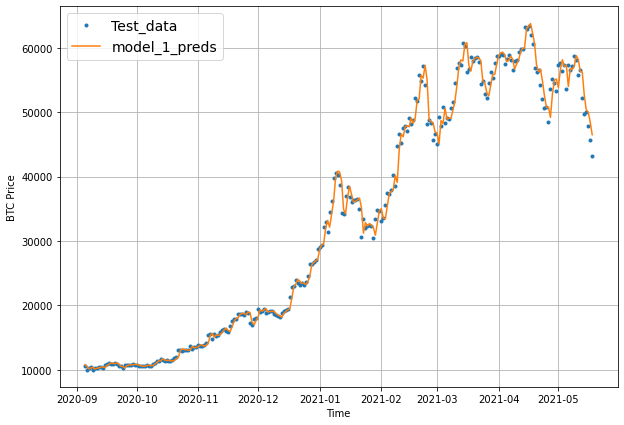

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.8796


659.879638671875

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 640.3601


640.360107421875

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57282.25 , 58460.6  , 59481.535, 57680.984, 56839.582, 54083.008,
       51319.5  , 50534.59 , 48419.055, 46611.42 ], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 640.3601,
 'mse': 1366768.8,
 'rmse': 1169.0889,
 'mape': 2.945051,
 'mase': 1.1193558}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1314.2085


1314.20849609375

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1227.6885


1227.6884765625

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[55781.887, 56132.758, 58251.363, 57499.297, 56999.477, 57321.72 ,
        57115.367],
       [57394.152, 56425.992, 58607.312, 58276.598, 57716.375, 58584.996,
        58217.582],
       [56698.18 , 58579.395, 59260.168, 58605.305, 60002.28 , 60510.176,
        59591.9  ],
       [58546.36 , 58300.742, 59707.62 , 59341.25 , 59852.047, 60371.934,
        59095.508],
       [56185.86 , 55915.66 , 58236.31 , 58954.508, 58311.438, 59536.61 ,
        59317.15 ]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  557.1112  ,   361.00586 ,   330.47504 ,   472.42117 ,
          499.33286 ,   580.5402  ,   617.434   ,   504.74658 ,
          528.67303 ,   631.3626  ,   829.4586  ,   864.38684 ,
          867.1192  ,   953.71063 ,   666.6915  ,   273.4322  ,
          196.27316 ,   234.48152 ,   250.60449 ,   222.8473  ,
          209.52916 ,   288.1976  ,   356.59528 ,   371.7819  ,
          159.61043 ,    95.31013 ,    96.90472 ,   171.89076 ,
          171.65186 ,   240.99525 ,   341.85764 ,   379.99805 ,
          422.21588 ,   363.29916 ,   332.83002 ,   310.7737  ,
          343.51736 ,   272.08853 ,   192.8591  ,   195.6866  ,
          445.01743 ,   113.39286 ,    96.92097 ,   167.88797 ,
          192.63058 ,   164.90115 ,   107.75565 ,    97.62284 ,
          104.39132 ,   190.18143 ,   145.68533 ,   229.3494  ,
          220.18625 ,   202.39803 ,   210.04199 ,   315.58197 ,
          559.6773  ,   494.4048  ,   446.38785 ,   534.1419  ,
          291.26556 ,   179.98576

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1227.6885,
 'mse': 5341943.5,
 'rmse': 1409.952,
 'mape': 5.605237,
 'mase': 2.1846032}

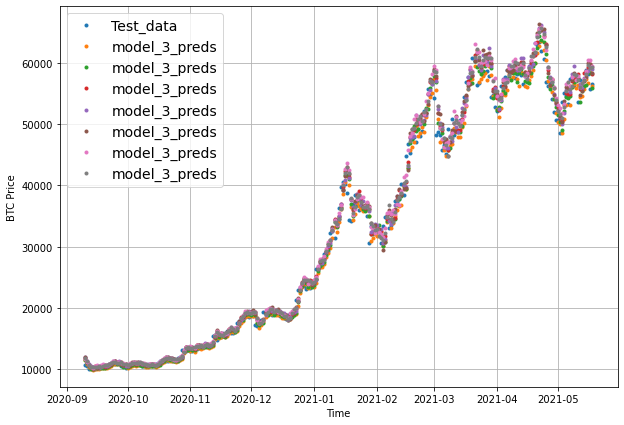

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

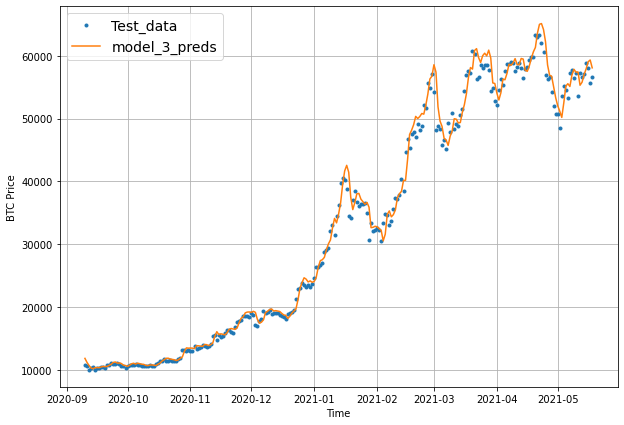

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

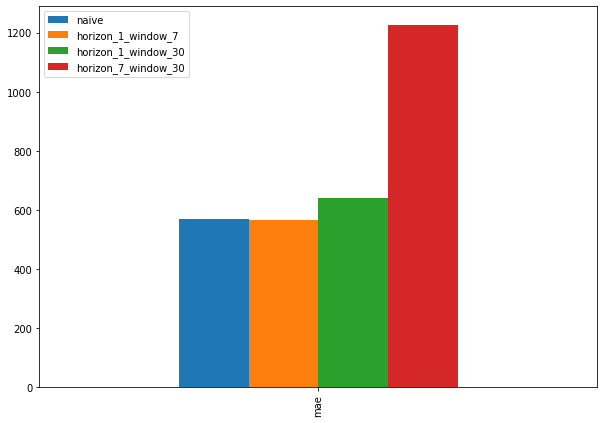

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 568.1141


568.1141357421875

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8861.868, 8772.314, 8999.378, 8774.765, 8714.461], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 568.11414,
 'mse': 1179648.6,
 'rmse': 1086.1163,
 'mape': 2.5468073,
 'mase': 0.99801916}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 146ms/step - loss: 2992.8337 - val_loss: 13203.4561
Epoch 2/100
18/18 [==============================] - 2s 128ms/step - loss: 1311.2872 - val_loss: 2854.8877
Epoch 3/100
18/18 [==============================] - 3s 154ms/step - loss: 298.9711 - val_loss: 1150.4583
Epoch 4/100
18/18 [==============================] - 3s 171ms/step - loss: 209.0929 - val_loss: 1044.9850
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 191.7458 - val_loss: 1113.2917
Epoch 6/100
18/18 [==============================] - 2s 123ms/step - loss: 185.7953 - val_loss: 1035.7115
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 184.8103 - val_loss: 1045.6906
Epoch 8/100
18/18 [==============================] - 3s 158ms/step - loss: 180.9494 - val_loss: 1003.2592
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 181.7980 - val_loss: 1034.2198
Epoch 10/100
18/18 [============================

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 586.3274


586.327392578125

In [76]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8944.6045, 8816.851 , 8985.306 , 8780.025 , 8757.795 , 8775.985 ,
       8685.057 , 8549.    , 8491.88  , 8518.701 ], dtype=float32)>

In [77]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 586.32745,
 'mse': 1231840.9,
 'rmse': 1109.8832,
 'mape': 2.6292033,
 'mase': 1.030015}

### Make a multivariate time series

In [78]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

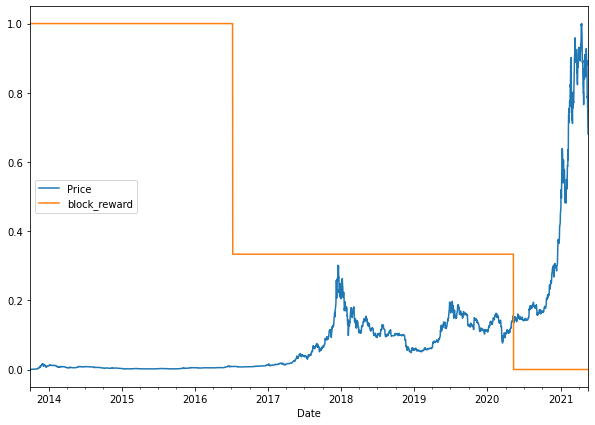

In [82]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [83]:
# Setup dataset hyperparameters

HORIZON = 1
WINDOW_SIZE = 7

In [84]:
# Make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [85]:
# Lets create X & y, remove the Nans and convert to float32 to prevent TensorFlow errors

X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [86]:
# View labels

y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Make train and tests

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [88]:
# Make multivariate time series model

tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # Layers.Dense(128, activation="relu"), # Adding an extra layer here should lead to beating the native model
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
# Make sure best model is loaded and evaluate

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 570.6213


570.6212768554688

In [90]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8846.895 , 8779.7295, 9047.94  , 8826.801 , 8745.201 , 8708.5   ,
       8698.176 , 8519.567 , 8461.251 , 8530.701 ], dtype=float32)>

In [91]:
# Evaluate preds

model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 570.6212,
 'mse': 1182688.8,
 'rmse': 1087.5149,
 'mape': 2.548643,
 'mase': 1.0024234}

In [92]:
model_1_results

{'mae': 564.1018,
 'mse': 1161677.5,
 'rmse': 1077.8114,
 'mape': 2.5241752,
 'mase': 0.9909706}

### Model 7: N-BEATS algorithm

In [93]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes crae of all the parameters for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is theta layerwith linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

In [94]:
# Setup dummy NBeatsBlock layer to represent inouts and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [95]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.15005496  0.65302974  0.25394973 -0.81874514  0.23884109  0.0145327
  0.49370998]
Forecast: 0.5248045325279236


### Preparing data for N-BEATS algorithm using tf.data

In [97]:
HORIZON = 1 # how far to predict
WINDOW_SIZE = 7 # how far to lookback

In [98]:
# Create NBEATS data inputs
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [99]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [100]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [101]:
# 1. Turn train and test sets into tensor datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [102]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

In [103]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, Compiling and Fitting the N-BEATS algorithm

In [104]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name="subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):

  # 5. Use the NBeatsBlock to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile the model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 207: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 307: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 47s, sys: 2.08 s, total: 1min 49s
Wall time: 1min 58s


In [105]:
# Evaluate N-BEATS model on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 577.7901 - mae: 577.7901 - mse: 1174311.2500


[577.7901000976562, 577.7901000976562, 1174311.25]

In [106]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8929.077, 8823.888, 9058.957, 8841.544, 8757.182, 8784.813,
       8706.831, 8556.843, 8509.234, 8549.504], dtype=float32)>

In [107]:
# Evaluate N-BEATS model prediction
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 577.7901,
 'mse': 1174311.2,
 'rmse': 1083.6564,
 'mape': 2.6312177,
 'mase': 1.0150172}

### Plotting N-BEATS architecture we have created

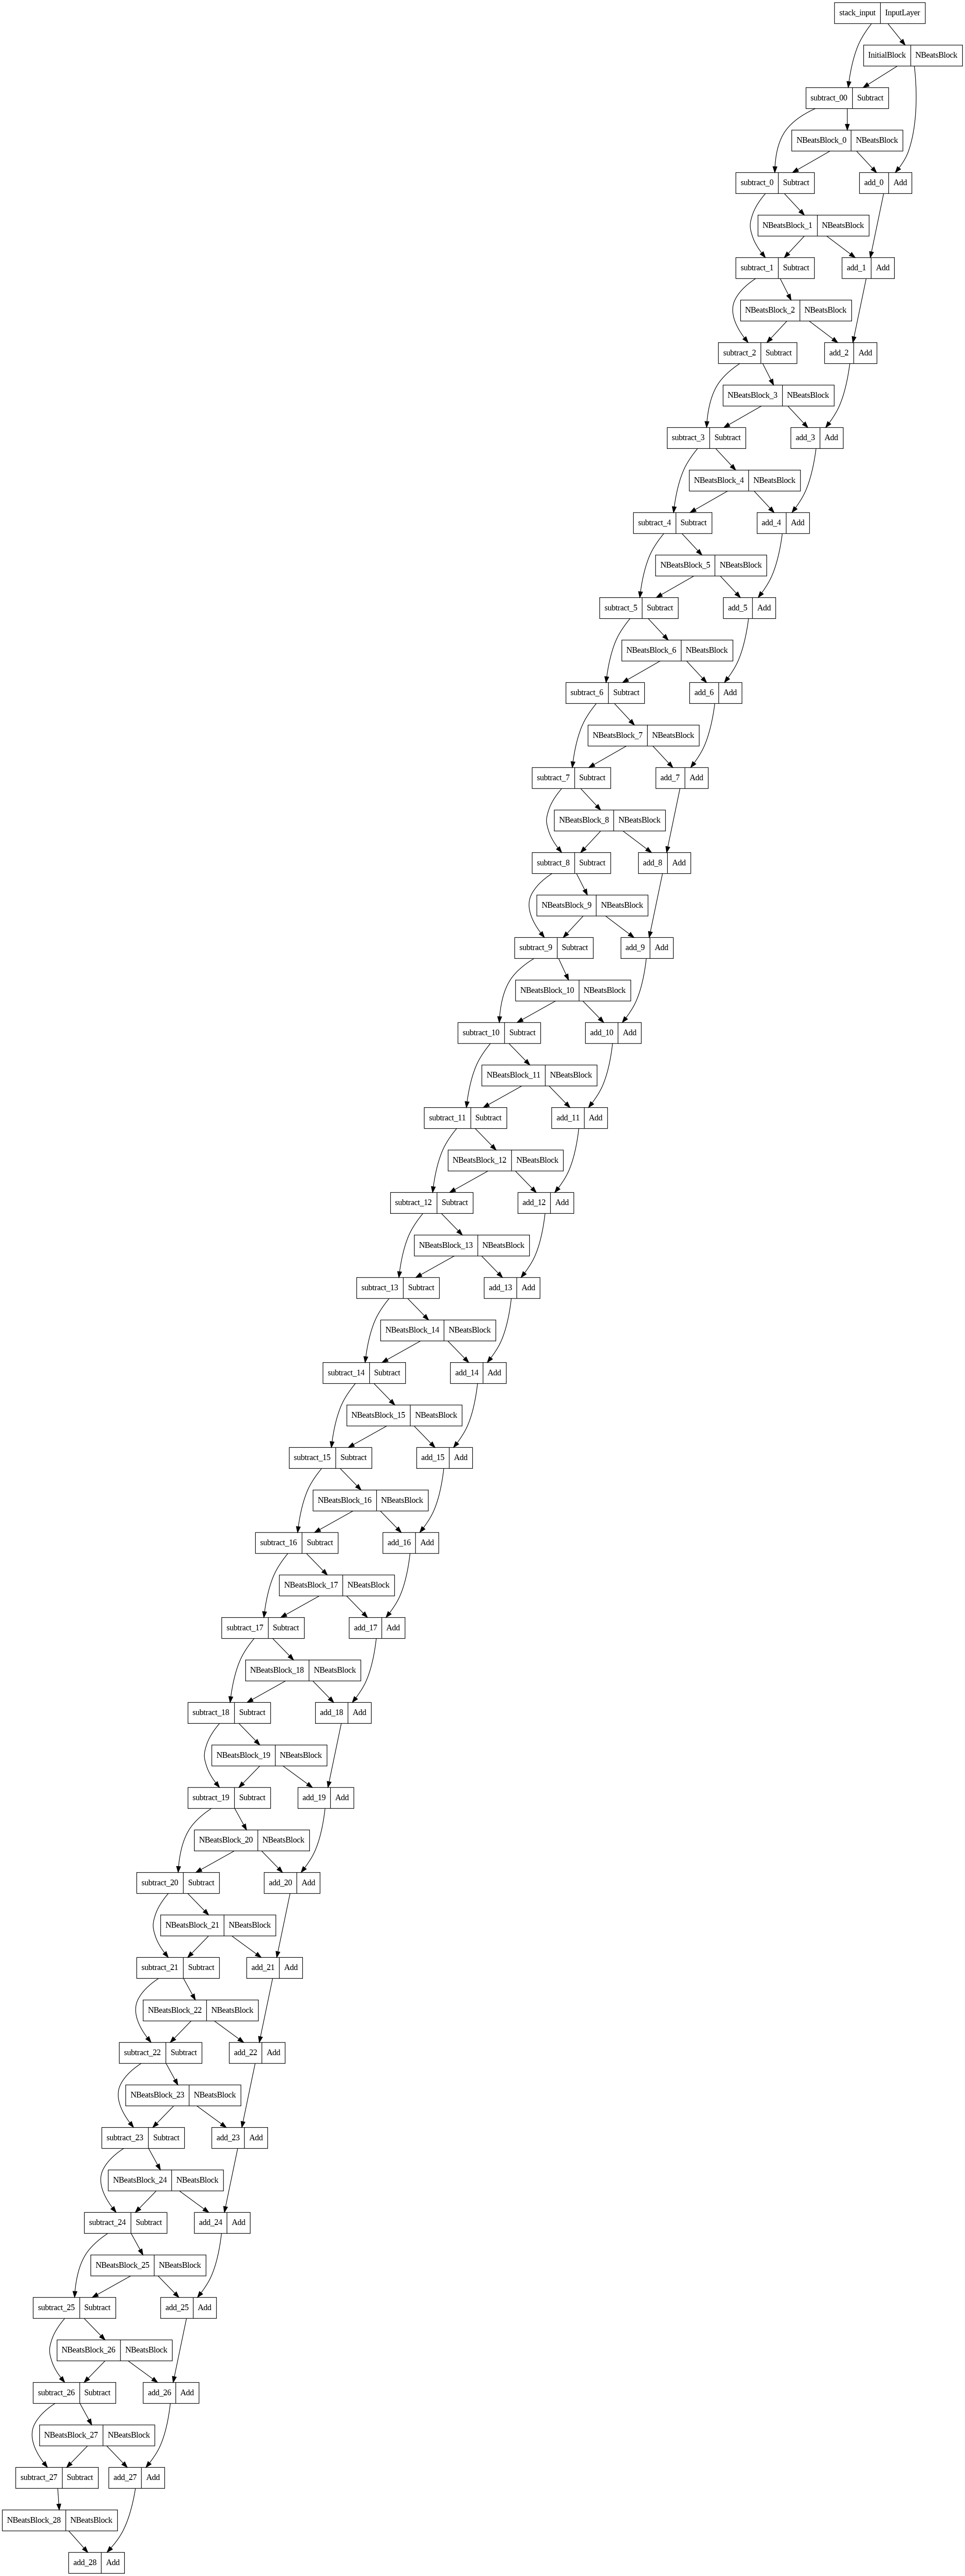

In [108]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [109]:
model_7.save(model_7.name)

### Model 8: Creating an ensemble (stacking different models together)

In [110]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For eg. if num_iter=10, Total number of models returned=30
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
      
      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append the fitted to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [111]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 583: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 683: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 783: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 883: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 983: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 317: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 417: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 517: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 617: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 717: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.


### Make predictions with an ensemble model

In [112]:
# Create a function which uses a list of trained models to make and return a list of prediction

def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [113]:
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8743.75 ,  8685.568,  9016.527, ..., 49406.023, 48251.125,
        45882.73 ],
       [ 8773.825,  8767.368,  9002.946, ..., 49888.273, 48038.598,
        46464.77 ],
       [ 8775.611,  8788.371,  9036.47 , ..., 50153.793, 48051.48 ,
        46513.016],
       ...,
       [ 8728.78 ,  8714.363,  9026.233, ..., 49511.42 , 48203.984,
        46948.12 ],
       [ 8811.418,  8780.92 ,  9096.464, ..., 49923.96 , 48509.08 ,
        45272.402],
       [ 8808.911,  8796.06 ,  9057.254, ..., 50195.316, 48274.918,
        46814.324]], dtype=float32)>

In [114]:
# Evaluate ensemble model(s) predictions

ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 573.59705,
 'mse': 1154462.4,
 'rmse': 1074.4591,
 'mape': 2.585712,
 'mase': 1.0076511}

### Plotting the prediction intervals of our ensemble model

In [115]:
# Find upper and lower bounds of ensemble prediction

def get_upper_lower(preds):
  
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

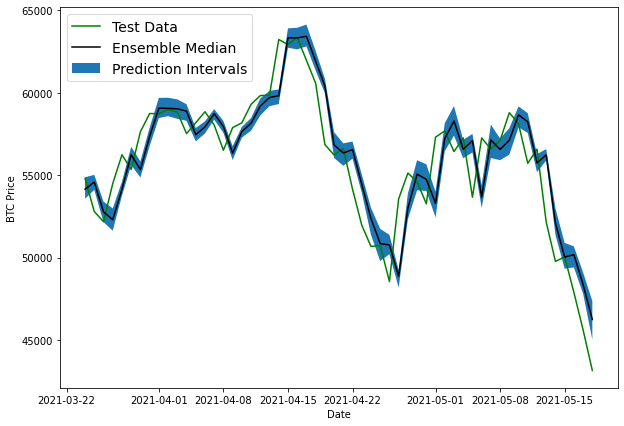

In [116]:
# Get the median values of our ensemble_preds

ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)


### Model 9: Train a model on full historical data to make predictions into future

In [117]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [118]:
# Train model on entire data to make predictions for the next day

X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [119]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [120]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions on the future

In [121]:
# How many timesteps to predict into the future?
INTO_FUTURE=14

In [122]:
# 1. Create a function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

# 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

# 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

# Predict on last window then append it again, again, again
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

# Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

# Update last window with new pred and get WINDOW_SIZE modt recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [123]:
future_forecast = make_future_forecast(values= y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 65ms/step
Predicting on 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55328.57421875

1/1 [==============================] - 0s 19ms/step
Predicting on 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55328.57421875] -> Prediction: 50572.4609375

1/1 [==============================] - 0s 20ms/step
Predicting on 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55328.57421875 50572.4609375 ] -> Prediction: 50260.51953125

1/1 [==============================] - 0s 20ms/step
Predicting on 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55328.57421875 50572.4609375  50260.51953125] -> Prediction: 47268.40625

1/1 [==============================] - 0s 19ms/step
Predicting on 
 [47885.62525472 45604.61575361 43144.47129086 55328.57421875
 50572.4609375  50260.51953125 47268.40625   ] 

In [124]:
future_forecast[:10]

[55328.574,
 50572.46,
 50260.52,
 47268.406,
 46756.83,
 45732.926,
 47819.855,
 53638.184,
 49691.02,
 48884.453]

### Plot future forecasts

In [125]:
def get_future_dates(start_date, into_future, offset=1):

  satrt_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [126]:
# Last timestep of timesteps (currently in np.datetime64 format)

last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [127]:
# Get nest two weeks of timesteps

next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31'], dtype='datetime64[D]')

In [128]:
# Insert last timestep/final price so the graph doesn't look messed

next_time_steps =np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-18', '2021-05-19', '2021-05-20',
        '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24',
        '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28',
        '2021-05-29', '2021-05-30', '2021-05-31'], dtype='datetime64[D]'),
 array([43144.473, 55328.574, 50572.46 , 50260.52 , 47268.406, 46756.83 ,
        45732.926, 47819.855, 53638.184, 49691.02 , 48884.453, 45792.535,
        46740.42 , 47031.23 , 50050.07 ], dtype=float32))

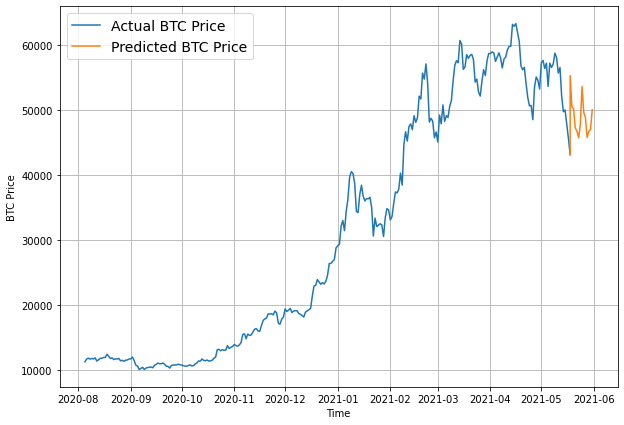

In [129]:
# Plot future price predictions of bitcoin

plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

### Model 10: Why forecasting is BS (the turkey problem)

The story - a turkey lives a good life for 1000 days, being fed everyday and taken care of by its owners until the evening before Thanksgiving.

In [134]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in 1 day)

btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [135]:
# Manufacturing an extra price on the end (to showcase the turkey problem)

btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [136]:
# Get timesteps for the turkey problem

btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

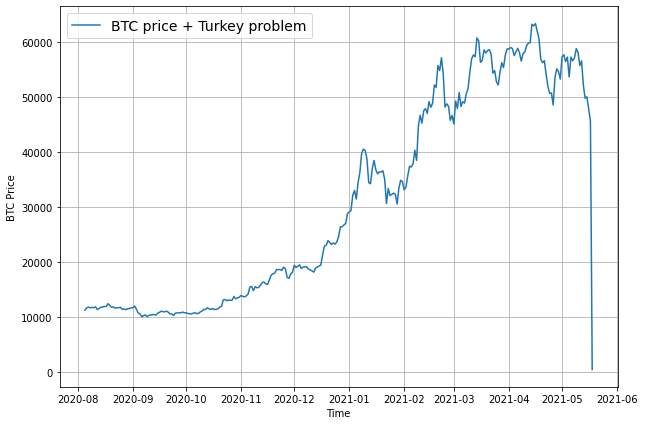

In [137]:
# Plot

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC price + Turkey problem",
                 start=2500)

In [138]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_split(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)